# TP2: Détection de menaces radar


    
 

    
 

>[TP2: Détection de menaces radar](#scrollTo=955fef7e)

>>[Mission](#scrollTo=fPp-jZ4oPXHY)

>>[Imports](#scrollTo=5BfWiQP-bxLN)

>>[DATA extraction](#scrollTo=MlwJmOK0ooaU)

>>>[TRAIN DATA](#scrollTo=k9CiLI1jYjx-)

>>>[TEST DATA](#scrollTo=UokvSuBzbe0Q)

>>>[Data visualization](#scrollTo=6x1HYB5FnWCQ)

>>[Feature extraction and selection](#scrollTo=i1iWDgK-nKPp)

>>[Classification](#scrollTo=UCgqkvqIo2OY)

>>>[Data](#scrollTo=A2DoXT_ixb6n)

>>>[Support vector machines](#scrollTo=rWlvJDESyQ8n)

>>>[Logistic Regression](#scrollTo=Pl55a9LbyeMH)

>>>[Random Forest](#scrollTo=Ttx1jGrRysuJ)

>>>[Decision trees](#scrollTo=dh11RHVyzChF)

>>>[K nearest neighbor](#scrollTo=z43pK6LJzXrU)

>>[Evaluation](#scrollTo=-LWIF05bztnJ)

>[Conclusion:](#scrollTo=HxNCYJs3gWMB)



## Mission




Vous commandez un avion de reconnaissance en mission top secrète. Malgré votre discretion et toutes les précautions prises vous dérangez et pouvez être sujet de menaces qu'il vous faut détecter pour garantir la sécurité de votre équipage et la succès de votre mission (comme elle est top secrète vous ne pouvez pas en savoir plus). 

A votre disposition un réseau d'antennes et un système d'analyse spectrale perfectionnés vous permettent d'extraire et de caractériser des signaux en provenance des radars à altitude 0 qui parsèment votre parcours. 

Un signal radar est composé d'impulsions. Le système d'analyse vous permettent de caractériser chaque impulsion reçue par un PDW (Pulse Description Word) qui contient: 

- la date de début de détection de l'impulsion (en ms)
- la largeur ou durée de l'impulsion (en ms)
- la puissance de l'impulsion (en dB / référence) 
- l'angle theta et l'angle phi décrivant la direction dans laquelle l'impulsion est détectée (en radians)
- la fréquence de l'impulsion (en Ghz)

Votre capteur n'est pas parfait et vous subissez notamment un phénomène de mitage: une certaine proportion des impulsions émises ne sont pas détectées. Cette proportion est d'autant plus grande que la puissance des impulsions est petite.  

Votre vaisseau navigue à 10 km d'altitude, avec une vitesse constante de 1000 km/h vers le nord. 

De précédentes missions ont permis de réaliser une base de données de signaux de 10 secondes. 
Chaque signal se présente sous la forme d'un fichier .npz qui contient l'ensemble des PDW reçus. 

Un signal est donc un fichier dont le nom est de la forme 'pdw_<numéro du signal>.npz'.

Cette base de données est annotée: le destin de chaque mission a permis de déclarer chaque signal comme une 'menace' ou une 'nonmenace'. 

Les signaux ont été divisés en deux ensembles indépendants: 
    - train
    - test 
 
Les annotations pour chaque ensemble sont disponibles dans le fichier labels_<train ou test>.json qui donne l'association nom de fichier -> menace ou nonmenace. 
   
Votre mission (si vous l'acceptez) est de choisir et d'entrainer un algorithme d'apprentissage machine à détecter les menaces sur l'ensemble 'train' et à évaluer ses performances sur l'ensemble 'test'. 

Fort de votre expérience passée, vous décidez de suivre la méthodologie suivante: 

    - Visualisation et analyse des données pour trouver les paramètres les plus pertinents à utiliser 
    - Sélection d'un algorithme naïf de référence: vous définissez un premier algorithme ad hoc et à la main et caractérisez ses performances 
    - Vous utilisez la bibliothèque sklearn et notamment ses implémentations d'algorithmes de classification binaire pour définir et entrainer sur l'ensemble 'train' un ou plusieurs algorithmes en capacité de prédire le label menance ou nonmenace de chaque signal (https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
    - Vous qualifiez les performances de vos algorithmes en termes d'accuracy (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) ; vous calculez aussi les matrices de confusion (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)

##Imports 

In [19]:
#Arrays,Plots and dataframes 
import json
import statistics 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

#Normalizing data
from sklearn.preprocessing import (MinMaxScaler,StandardScaler)

#Feature Selection
from sklearn.feature_selection import SelectKBest, f_classif

#Metrics
from sklearn import metrics
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                             classification_report, roc_curve, auc, cohen_kappa_score)
#Logistic Regression
from sklearn.linear_model import LogisticRegression

#SVMs
from sklearn import svm

#kNN
from sklearn.neighbors import KNeighborsClassifier

#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

#model selection 
from sklearn.model_selection import GridSearchCV

#Decision Tree
from sklearn.tree import DecisionTreeClassifier

#Evaluation
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## DATA extraction 

In this section we're going to extract the data from the folders. The data processing is minimal for this project since that the data is already cleaned.

Every signal is carracterized by a set of features that we're going to analyze and visualize in order to choose the right features 

### TRAIN DATA

In [6]:
#intermediate function to calculate pulse in features 
def Pulse(L):
  res=[0]
  for i in range(len(L)-1):
    res.append(L[i]-L[i+1])
  return res

In [4]:
#open json of labels for training data as dict
with open('/content/drive/MyDrive/MVA/Traitement de signal/TP/TP2 /train_labels.json') as f: 
    dict_labels = json.load(f)

#convert to list
#Y represents the list of labels for the training signals  
Y=[0]*len(dict_labels)
for i in range(len(dict_labels)):
  if dict_labels[f'pdw-{i}']=='menace':
    Y[i]=1

#visualize some labels
for i in range(10):
    print(f"Le signal pdw-{i}.npz est de type: {dict_labels[f'pdw-{i}']}")

Le signal pdw-0.npz est de type: nonmenace
Le signal pdw-1.npz est de type: nonmenace
Le signal pdw-2.npz est de type: menace
Le signal pdw-3.npz est de type: nonmenace
Le signal pdw-4.npz est de type: nonmenace
Le signal pdw-5.npz est de type: menace
Le signal pdw-6.npz est de type: menace
Le signal pdw-7.npz est de type: menace
Le signal pdw-8.npz est de type: menace
Le signal pdw-9.npz est de type: nonmenace


As presented in the introduction the features of a radar signal are the width, frequences, energy, and the angles phi and theta 

*we convert to lists to simplify the processing steps*

In [7]:
#load features for training data 
dates=[]
width=[]
frequence=[]
energy=[]
theta=[]
phi=[]
pulse=[]
for i in range(len(dict_labels)):
  pdws = np.load(f'/content/drive/MyDrive/MVA/Traitement de signal/TP/TP2 /train/pdw-{i}.npz')
  dates.append(list(pdws['date']))
  pulse.append(Pulse(list(pdws['date'])))
  width.append(list(pdws['largeur']))
  frequence.append(list(pdws['frequence']))
  energy.append(list(pdws['puissance']))
  theta.append(list(pdws['theta']))
  phi.append(list(pdws['phi']))

### TEST DATA 

We perform the same steps to extract the training data 

In [8]:
#open json of labels for testing data as dict
with open('/content/drive/MyDrive/MVA/Traitement de signal/TP/TP2 /test_labels.json') as f: 
    dict_labels_test = json.load(f)

#convert to list
#Y_t is the list of labels for testing data 
Y_t=[0]*len(dict_labels_test)
for i in range(len(dict_labels_test)):
  if dict_labels_test[f'pdw-{i}']=='menace':
    Y_t[i]=1

#visualize some labels
for i in range(10):
    print(f"Le signal de test  pdw-{i+2000}.npz est de type: {dict_labels_test[f'pdw-{i}']}")

Le signal pdw-2000.npz est de type: menace
Le signal pdw-2001.npz est de type: menace
Le signal pdw-2002.npz est de type: nonmenace
Le signal pdw-2003.npz est de type: nonmenace
Le signal pdw-2004.npz est de type: nonmenace
Le signal pdw-2005.npz est de type: menace
Le signal pdw-2006.npz est de type: nonmenace
Le signal pdw-2007.npz est de type: menace
Le signal pdw-2008.npz est de type: menace
Le signal pdw-2009.npz est de type: menace


In [9]:
#load features for training data 
dates_test=[]
width_test=[]
frequence_test=[]
energy_test=[]
theta_test=[]
phi_test=[]
pulse_test=[]
for i in range(len(dict_labels_test)):
  pdws = np.load(f'/content/drive/MyDrive/MVA/Traitement de signal/TP/TP2 /test/pdw-{i}.npz')
  dates_test.append(list(pdws['date']))
  pulse_test.append(Pulse(list(pdws['date'])))
  width_test.append(list(pdws['largeur']))
  frequence_test.append(list(pdws['frequence']))
  energy_test.append(list(pdws['puissance']))
  theta_test.append(list(pdws['theta']))
  phi_test.append(list(pdws['phi']))



> Here we finished the data extraction step the various lists contain the data needed for training and testing the next step is visualizing the features and comparing them between malicious signals and safe ones 



### Data visualization

Text(0.5, 1.0, 'Malicious radar feature energy')

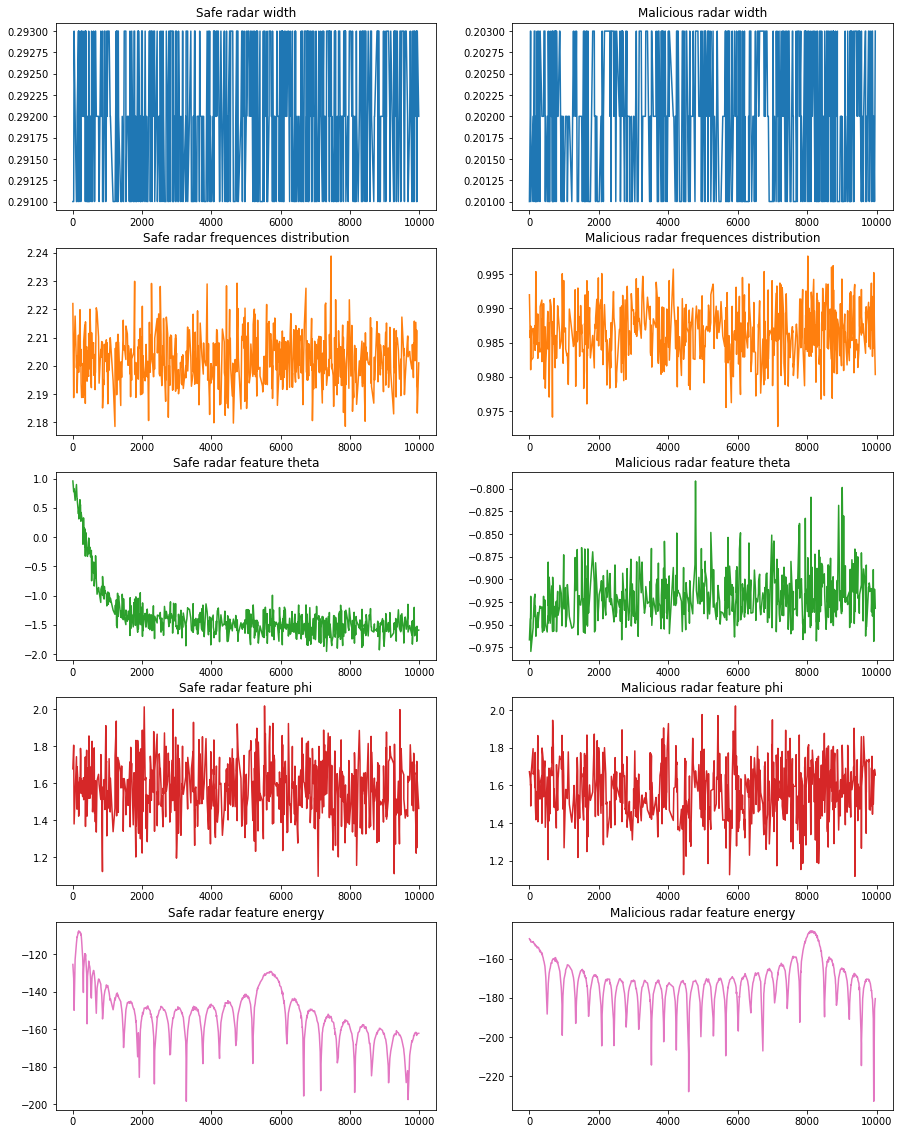

In [10]:
#Visualize some examples : for malicious radar we use pdw-2 and for safe radar we use pdw-0
#####Parameters######
mal_radar=2         #malicious signal index
safe_radar=0        #safe signal test
#####################

fig, axs = plt.subplots(5, 2, figsize=(15,20))

#safe radar
axs[0, 0].plot(dates[safe_radar],width[safe_radar])
axs[0, 0].set_title('Safe radar width')
axs[1, 0].plot(dates[safe_radar], frequence[safe_radar], 'tab:orange')
axs[1, 0].set_title('Safe radar frequences distribution')
axs[2, 0].plot(dates[safe_radar], theta[safe_radar], 'tab:green')
axs[2, 0].set_title('Safe radar feature theta')
axs[3, 0].plot(dates[safe_radar], phi[safe_radar], 'tab:red')
axs[3, 0].set_title('Safe radar feature phi')
axs[4, 0].plot(dates[safe_radar], energy[safe_radar], 'tab:pink')
axs[4, 0].set_title('Safe radar feature energy')
#safe radar
axs[0, 1].plot(dates[mal_radar],width[mal_radar])
axs[0, 1].set_title('Malicious radar width')
axs[1, 1].plot(dates[mal_radar], frequence[mal_radar], 'tab:orange')
axs[1, 1].set_title('Malicious radar frequences distribution')
axs[2, 1].plot(dates[mal_radar], np.tanh(theta[mal_radar]), 'tab:green')
axs[2, 1].set_title('Malicious radar feature theta')
axs[3, 1].plot(dates[mal_radar], phi[mal_radar], 'tab:red')
axs[3, 1].set_title('Malicious radar feature phi')
axs[4, 1].plot(dates[mal_radar], energy[mal_radar], 'tab:pink')
axs[4, 1].set_title('Malicious radar feature energy')

Interpretation


> To start we can notice diffrences in the range of distributions for energy width and frequences hence we can use features such as the max, min and mean of esch of of these features 



## Feature extraction and selection  

This first step is converting the lists of fetures into dataframes **After further testing this step could be done differently but generally helps imagine different ways to proceed the training but for the final form we got to it isn't necessary**

In [11]:
#training data 
Features=[width, frequence,energy, theta, phi,pulse,dates]
Cleaned_features_train=[]
for f in Features:
  Colnames=[str(k) for k in range(20014)]
  df= pd.DataFrame(f,columns=Colnames)
  #df=df.dropna(axis=1)
  #print(df.shape)
  Cleaned_features_train.append(df)

#testing data 
Features=[width_test, frequence_test,energy_test, theta_test, phi_test,pulse_test,dates_test]
Cleaned_features_test=[]
for f in Features:
  Colnames=[str(k) for k in range(19065)]
  df= pd.DataFrame(f,columns=Colnames)
  #df=df.dropna(axis=1)
  #print(df.shape)
  Cleaned_features_test.append(df)

Feature extraction is an important step in constructing an effective machine learning algorithm for that we're going to use documentation on the topic to choose the most effective features. 
The publiced paper used is :


*   [Radar Emitter Signals Recognition and Classification with
Feedforward Networks](https://reader.elsevier.com/reader/sd/pii/S187705091300999X?token=EA95486E082ECE7C107968D06CB6D52322143F1505D1FBC5AF9851219C52D1DCC9CE5E721A6B8642011D11EB9961FDDC&originRegion=eu-west-1&originCreation=20221107130518)

*From this paper we can conclude that from the available data the key features for radar detection are the max, min and mean of the energy, frequency and width and the mean of the pulse*

Additionally we're going to perform some data exploration in order to examine potential features that give better results 



In [53]:
#train features
Features_train=np.array(list(zip( *[
    list(np.max(Cleaned_features_train[0], axis=1)),
    list(np.min(Cleaned_features_train[0], axis=1)),
    list(np.mean(Cleaned_features_train[0], axis=1)),
    list(np.var(Cleaned_features_train[0], axis=1)),
    list(np.max(Cleaned_features_train[1], axis=1)),
    list(np.min(Cleaned_features_train[1], axis=1)),
    list(np.mean(Cleaned_features_train[1], axis=1)),
    list(np.var(Cleaned_features_train[1], axis=1)),
    list(np.max(Cleaned_features_train[2], axis=1)),
    list(np.min(Cleaned_features_train[2], axis=1)),
    list(np.mean(Cleaned_features_train[2], axis=1)),
    list(np.var(Cleaned_features_train[3], axis=1)),
    list(np.max(Cleaned_features_train[3], axis=1)),
    list(np.min(Cleaned_features_train[3], axis=1)),
    list(np.mean(Cleaned_features_train[3], axis=1)),
    list(np.var(Cleaned_features_train[3], axis=1)),
    list(np.max(Cleaned_features_train[4], axis=1)),
    list(np.min(Cleaned_features_train[4], axis=1)),
    list(np.mean(Cleaned_features_train[4], axis=1)),
    list(np.var(Cleaned_features_train[4], axis=1)),
    list(np.max(Cleaned_features_train[5], axis=1)),
    list(np.min(Cleaned_features_train[5], axis=1)),
    list(np.mean(Cleaned_features_train[5], axis=1)),
    list(np.var(Cleaned_features_train[5], axis=1)),

])))
    

In [54]:
#test features
Features_test=np.array(list(zip( *[
    list(np.max(Cleaned_features_test[0], axis=1)),
    list(np.min(Cleaned_features_test[0], axis=1)),
    list(np.mean(Cleaned_features_test[0], axis=1)),
    list(np.var(Cleaned_features_test[0], axis=1)),
    list(np.max(Cleaned_features_test[1], axis=1)),
    list(np.min(Cleaned_features_test[1], axis=1)),
    list(np.mean(Cleaned_features_test[1], axis=1)),
    list(np.var(Cleaned_features_test[1], axis=1)),
    list(np.max(Cleaned_features_test[2], axis=1)),
    list(np.min(Cleaned_features_test[2], axis=1)),
    list(np.mean(Cleaned_features_test[2], axis=1)),
    list(np.var(Cleaned_features_test[2], axis=1)),
    list(np.max(Cleaned_features_test[3], axis=1)),
    list(np.min(Cleaned_features_test[3], axis=1)),
    list(np.mean(Cleaned_features_test[3], axis=1)),
    list(np.var(Cleaned_features_test[3], axis=1)),
    list(np.max(Cleaned_features_test[4], axis=1)),
    list(np.min(Cleaned_features_test[4], axis=1)),
    list(np.mean(Cleaned_features_test[4], axis=1)),
    list(np.var(Cleaned_features_test[4], axis=1)),
    list(np.max(Cleaned_features_test[5], axis=1)),
    list(np.min(Cleaned_features_test[5], axis=1)),
    list(np.mean(Cleaned_features_test[5], axis=1)),
    list(np.var(Cleaned_features_test[5], axis=1)),
])))

**Features before selection**

In [55]:
Colnames=['max width', 'min width','mean width','var width',
          'max frequency', 'min frequency','mean frequency','var frequency',
          'max energy', 'min energy','mean energy','var energy',
          'max theta', 'min theta','mean theta','var theta',
          'max phi', 'min phi','mean phi','var phi',
          'max pulse', 'min pulse','mean pulse','var pulse']
Features_train=pd.DataFrame(Features_train, columns=Colnames)
Features_test=pd.DataFrame(Features_test, columns=Colnames)
Features_train.head()

,max width,min width,mean width,var width,max frequency,min frequency,mean frequency,var frequency,max energy,min energy,...,mean theta,var theta,max phi,min phi,mean phi,var phi,max pulse,min pulse,mean pulse,var pulse
0,0.293,0.291,0.292003,6.874911e-07,2.238800,2.178543,2.202149,0.000079,-107.706444,-198.439372,...,-1.334458,0.227938,2.018851,1.097684,1.574437,0.024149,0.0,-84.352,-14.857665,185.698083
1,0.138,0.136,0.137017,6.565220e-07,3.031234,2.946963,2.996037,0.000152,-127.176800,-210.067261,...,-1.634125,0.121098,2.207375,1.000649,1.570940,0.026166,0.0,-65.119,-9.246226,78.610172
2,0.203,0.201,0.201962,6.788865e-07,0.997647,0.972759,0.986435,0.000016,-145.868879,-232.867752,...,-1.607840,0.026848,2.021743,1.116303,1.571787,0.023729,0.0,-113.615,-15.673087,220.358686
3,0.070,0.068,0.069014,6.604463e-07,1.691682,1.640058,1.665592,0.000044,-132.493661,-209.155813,...,-1.690380,0.045515,2.210000,0.998426,1.585633,0.026284,0.0,-60.198,-6.951435,46.091113
4,0.325,0.323,0.324018,6.613867e-07,2.229983,2.182394,2.205039,0.000073,-148.379465,-232.332658,...,-1.559266,0.455257,2.092829,0.836817,1.578277,0.026216,0.0,-125.830,-16.458287,262.524725


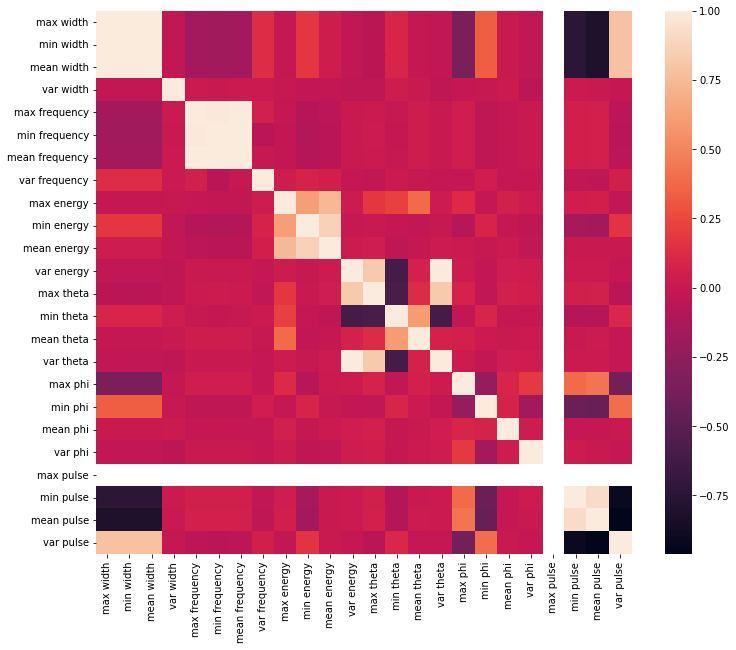

In [57]:
# Correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(Features_train.corr());

**Next we are going to perform feature selection**

Feature selection is the process of reducing the number of input variables when developing a predictive model.

It is desirable to reduce the number of input variables to both reduce the computational cost of modeling and, in some cases, to improve the performance of the model.

Statistical-based feature selection methods involve evaluating the relationship between each input variable and the target variable using statistics and selecting those input variables that have the strongest relationship with the target variable. These methods can be fast and effective, although the choice of statistical measures depends on the data type of both the input and output variables.

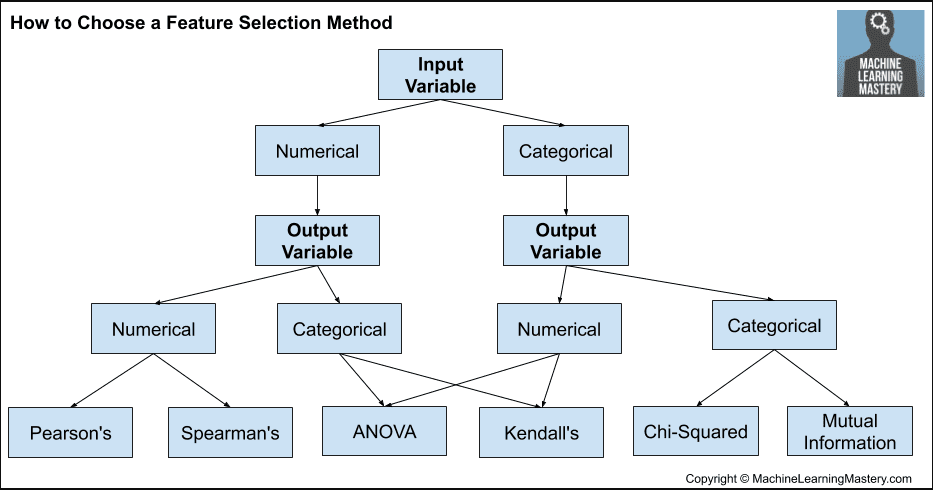

We are dealing with a classification problem with numerical input for this reason we're going to use either the ANOVA method or Kendall's

**ANOVA**: The scikit-learn machine library provides an implementation of the ANOVA f-test in the f_classif() function. This function can be used in a feature selection strategy, such as selecting the top k most relevant features (largest values) via the SelectKBest class.

In [82]:
#Feature selection for training data 
Selector=SelectKBest(f_classif, k = 15)
Feat_selected = Selector.fit_transform(Features_train, Y)
Feat_names=Selector.get_feature_names_out()
Feat_selected_train = pd.DataFrame(Feat_selected,columns = Feat_names)
Feat_selected_train.head()

,max width,min width,mean width,max frequency,min frequency,mean frequency,var frequency,max energy,min energy,mean energy,max phi,var phi,min pulse,mean pulse,var pulse
0,0.293,0.291,0.292003,2.238800,2.178543,2.202149,0.000079,-107.706444,-198.439372,-151.168286,2.018851,0.024149,-84.352,-14.857665,185.698083
1,0.138,0.136,0.137017,3.031234,2.946963,2.996037,0.000152,-127.176800,-210.067261,-152.733649,2.207375,0.026166,-65.119,-9.246226,78.610172
2,0.203,0.201,0.201962,0.997647,0.972759,0.986435,0.000016,-145.868879,-232.867752,-171.253159,2.021743,0.023729,-113.615,-15.673087,220.358686
3,0.070,0.068,0.069014,1.691682,1.640058,1.665592,0.000044,-132.493661,-209.155813,-149.829714,2.210000,0.026284,-60.198,-6.951435,46.091113
4,0.325,0.323,0.324018,2.229983,2.182394,2.205039,0.000073,-148.379465,-232.332658,-177.214144,2.092829,0.026216,-125.830,-16.458287,262.524725


In [83]:
#Feature selection for testing 
Feat_selected = Selector.transform(Features_test)
Feat_selected_test = pd.DataFrame(Feat_selected,columns = Feat_names)
Feat_selected_test.head()

,max width,min width,mean width,max frequency,min frequency,mean frequency,var frequency,max energy,min energy,mean energy,max phi,var phi,min pulse,mean pulse,var pulse
0,0.250,0.248,0.248983,1.275481,1.244718,1.262377,0.000026,-123.336834,-205.946737,-160.921450,2.062907,0.024465,-74.495,-10.532450,93.441556
1,0.275,0.273,0.274015,1.031440,0.846323,0.936235,0.002916,-97.283248,-130.157090,-120.776315,2.042610,0.028228,-136.667,-15.391528,219.478173
2,0.280,0.278,0.279004,1.350749,1.316874,1.334002,0.000025,-134.121699,-215.723234,-160.235629,1.974096,0.024200,-140.263,-14.927797,262.987651
3,0.130,0.128,0.129001,1.556579,1.517903,1.537033,0.000038,-97.218337,-216.375757,-153.211649,2.021146,0.025373,-104.591,-14.133643,185.930854
4,0.190,0.188,0.189011,1.952008,1.906204,1.928637,0.000062,-117.108615,-206.300343,-150.195466,2.051103,0.022656,-100.578,-15.485291,206.333293


## Classification 

The goal of this part is the classification of radar signals . The first step is normalizing the data. Then definning multiple ML models to do the classification:

* SVM (Support Vector Machine) is a discriminative classifier
defined by a separating hyperplane. The labelled training data are divided by an optimal hyperplane which could be used for categorizing new, untrained data.

* LR (Logistic Regression) is a common technique for
solving binary classification problem. It uses a logistic function to model a binary dependent variable, then use this trained function to classify untrained data.

* RF (Random Forest) is a classification technique that
leverage usage of multiple decision trees, each contains leaves representing class labels and branches representing conjunctions of features that lead to those labels. The trained decision trees are then used in a randomized fashion (therefore called Random Forest, in an attempt to overcome overfitting nature of decision trees) to classify an untrained data

* DT (Ddecision trees)is a supervised learning technique that has a pre-defined target variable and is most often used in classification problems. This tree can be applied to either categorical or continuous input & output variables. The training process resembles a flow chart, with each internal (non-leaf) node a test of an attribute, each branch is the outcome of that test, and each leaf (terminal) node contains a class label. The uppermost node in the tree is called the root node.
* K-NN (K nearest neighbor) classifier is simple, quick and effective. The hierarchical structure decomposes the classification task into a set of simpler problems, one at each node of the classification. Feature selection is embedded in the hierarchical framework that chooses the most relevant feature subsets at each node of the hierarchy.

### Data

In [87]:
#Train Test 
X_train, X_test, Y_train, Y_test =  Feat_selected_train, Feat_selected_test, Y, Y_t
print("Train predictor shape: ", X_train.shape)
print("Test predictor shape: ", X_test.shape)

#normalizing data 
normalizer = StandardScaler()
X_train= normalizer.fit_transform(X_train)
X_test=normalizer.transform(X_test)

print('Data normalized')

Train predictor shape:  (2000, 15)
Test predictor shape:  (800, 15)
Data normalized


### Support vector machines

The main challenge with svms is the choice of kernels. The process is testing the kernels and choosing the one that gives the best results. For this case we're going to use linear kernel

In [88]:
#modeling
from sklearn import svm
svm_ = svm.SVC(kernel='linear',probability=True)
svm_.fit(X_train, Y_train) 

#prediction 
svm_pred = svm_.predict(X_test)


### Logistic Regression
Logistic regression is easier to implement, interpret, and very efficient to train. It can easily extend to multiple classes(multinomial regression) and a natural probabilistic view of class predictions.

In [89]:
#modeling
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, Y_train)

#predictions
logistic_regression_pred = logistic_regression.predict(X_test)

### Random Forest


**Tune parameters with GridSearchCV**

In [90]:
#model
RandomforestClassifier=RandomForestClassifier()

# Use GridSearchCV to find best parameters for the Random Forest
params = {'n_estimators': [10, 100,150],
          'max_features': list(range(1,X_train.shape[1])),
          'max_depth': [20, 25]}

grid_forest = GridSearchCV(RandomforestClassifier, params, cv=3, n_jobs=-1)

grid_forest.fit(X_train, Y_train)

# View best score and parameters
print('Best score:', grid_forest.best_score_)
print('Best params:', grid_forest.best_params_)


Best score: 0.8659994327160744
Best params: {'max_depth': 25, 'max_features': 4, 'n_estimators': 150}


In [91]:
#modeling
RandomForestclassifier = RandomForestClassifier(max_depth=25,max_features=4,n_estimators=150).fit(X_train, Y_train)

#predictions
RandomForestclassifier_pred=RandomForestclassifier.predict(X_test)

### Decision trees

In [92]:
#model
Decisiontreeclassifier=DecisionTreeClassifier()

# Use GridSearchCV to find best parameters for the Random Forest
params = {'max_depth': np.arange(1,25,1)}

grid_tree = GridSearchCV(Decisiontreeclassifier, params, cv=3, n_jobs=-1)

grid_tree.fit(X_train, Y_train)

# View best score and parameters
print('Best score:', grid_tree.best_score_)
print('Best params:', grid_tree.best_params_)

Best score: 0.8509934222078149
Best params: {'max_depth': 9}


In [93]:
#modeling 
Decisiontreeclassifier = DecisionTreeClassifier(criterion = "entropy", max_depth = 9)
Decisiontreeclassifier=Decisiontreeclassifier.fit(X_train, Y_train)
#predictions
DecisionTreeClassifier_pred=Decisiontreeclassifier.predict(X_test)

### K nearest neighbor

**Optimal K**

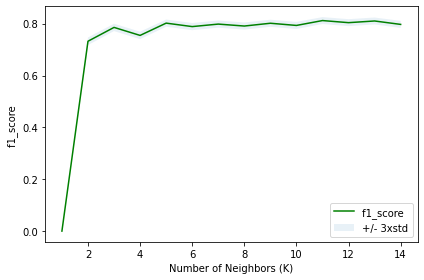

The best f1_score was with 0.8119891008174386 with k = 11


In [94]:
#KNN for different Ks
Ks = 15
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(2,Ks):
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train, Y_train)
    yhat = neigh.predict(X_test)
    
    #Computing the accuracy and its standard deviation
    mean_acc[n-1] = metrics.f1_score(Y_test, yhat)
    std_acc[n-1]= np.std(yhat == Y_test)/np.sqrt(yhat.shape[0])

#We plot our results
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('f1_score ', '+/- 3xstd'))
plt.ylabel('f1_score ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

print( "The best f1_score was with", mean_acc.max(), "with k =", mean_acc.argmax()+1) 

In [95]:
#modeling
KNN = KNeighborsClassifier(n_neighbors = 11).fit(X_train, Y_train)
#prediction 
KNN_pred = KNN.predict(X_test)

## Evaluation

We're going to use the following measures to evaluate the classifier we put in place

* Confusion Matrix: it is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known. 

* Accuracy: is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations. However, a high accuracy doesn’t mean that our model is best. It is a great measure indeed, but only when we have symmetric datasets where values of false positive and false negatives are almost same.

 

* Fscore is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F is usually more useful than accuracy, especially if we have an uneven class distribution.

* ROC Curve. The ROC curve is a graphical plot that illustrates the diagnostic ability of a binary class ifier system as its discrimination threshold is varied. We take under consideration the Area Under the Curve. In general, an AUC of 0.5 suggests no discrimination (i.e. ability to diagnose patients with and without the disease or condition based on the test), 0.7 to 0.8 is considered acceptable, 0.8 to 0.9 is considered excellent, and more than 0.9 is considered outstanding.

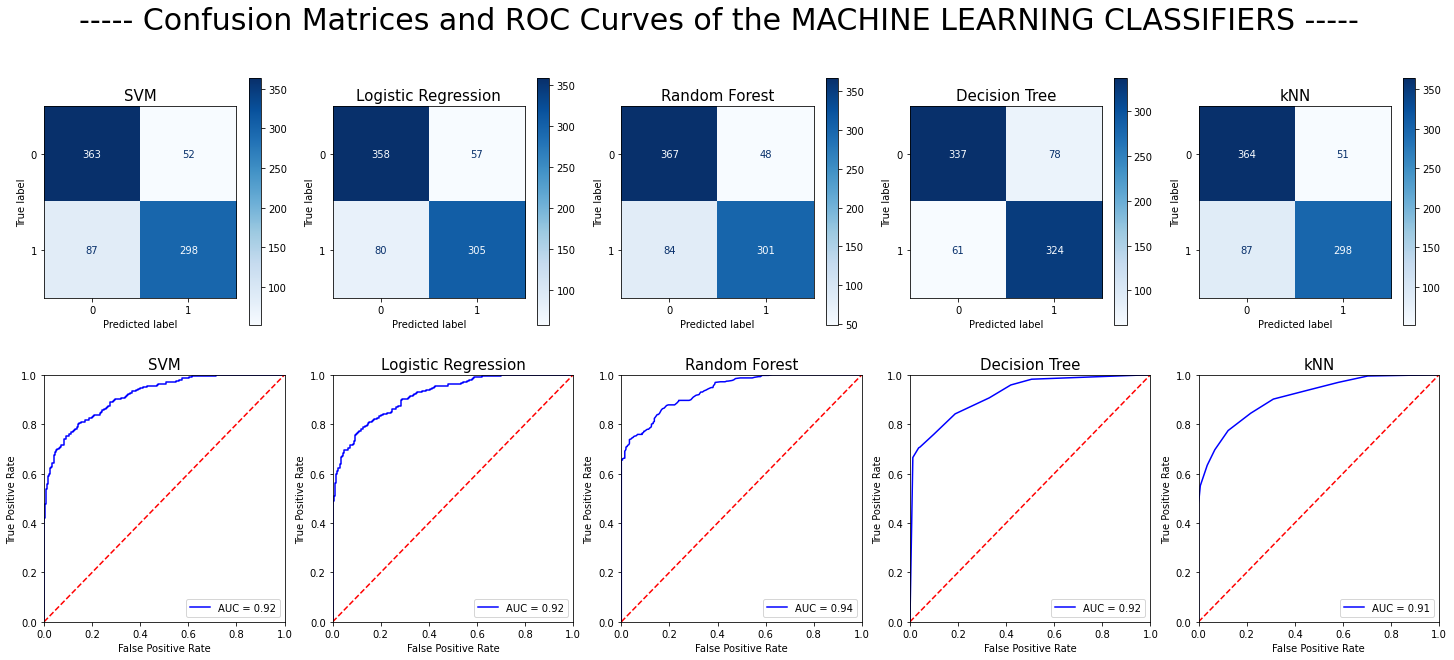

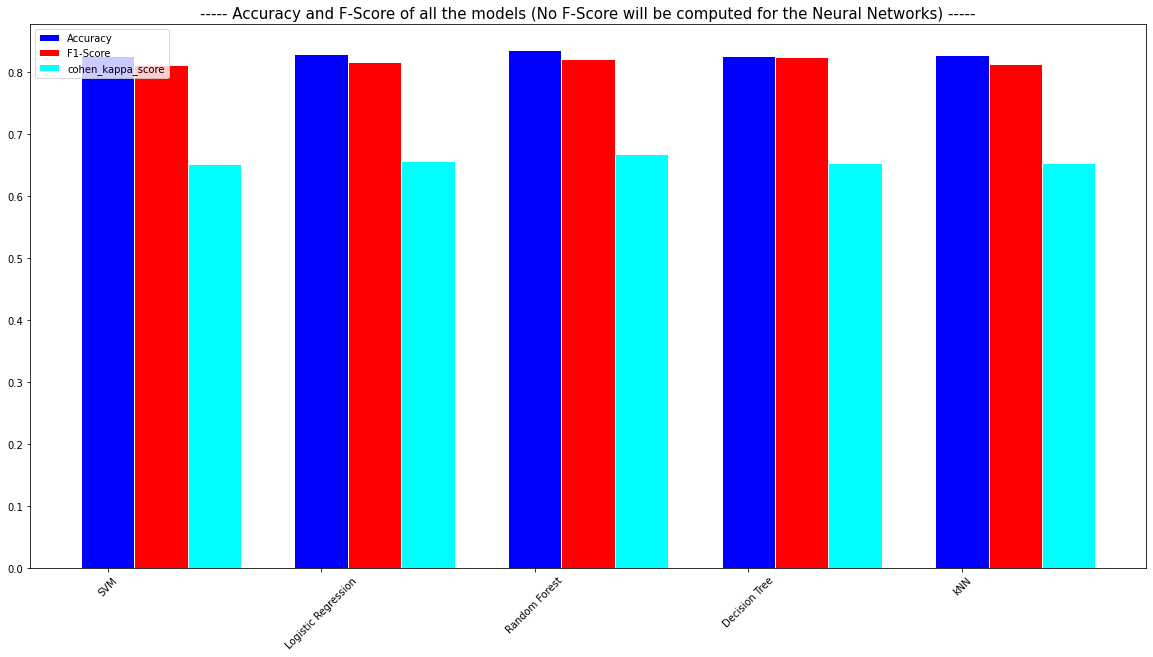

In [96]:
################################### CONFUSION MATRIX AND ROC CURVE ################################################

#Initializing the figure
fig, axs = plt.subplots(2, 5, figsize = (25, 10))

#Gathering the models
models = [svm_, logistic_regression, RandomForestclassifier,Decisiontreeclassifier, KNN]
names = ["SVM","Logistic Regression", "Random Forest","Decision Tree", "kNN"]

#Looping over the models
for i, clf in enumerate(models):

    #Confusion Matrix
    plot_confusion_matrix(clf, X_test, Y_test, cmap='Blues', ax = axs[0,i]) 
    axs[0,i].set_title(names[i], fontsize = 15)

    #ROC Curve
    y_scores = clf.predict_proba(X_test)
    FPR, TPR, threshold = roc_curve(Y_test, y_scores[:, 1])
    roc_auc = auc(FPR, TPR)

    axs[1,i].plot(FPR, TPR, 'b', label = 'AUC = %0.2f' % roc_auc)
    axs[1,i].legend(loc = 'lower right')
    axs[1,i].plot([0, 1], [0, 1],'r--')
    axs[1,i].set_title(names[i], fontsize = 15)
    axs[1,i].set_xlim([0, 1])
    axs[1,i].set_ylim([0, 1])
    axs[1,i].set_ylabel('True Positive Rate')
    axs[1,i].set_xlabel('False Positive Rate')

#Displaying the plot
plt.suptitle("----- Confusion Matrices and ROC Curves of the MACHINE LEARNING CLASSIFIERS -----", fontsize = 30)
plt.show()

###################################################################################################################
print("\n")
print("\n")
################################################ ACCURACY #########################################################

#Initializing
predicted_labels = [svm_pred,logistic_regression_pred, RandomForestclassifier_pred, DecisionTreeClassifier_pred, KNN_pred]
accuracies = []
f1_scores = []
cohenkappa_score=[]



#Looping over the models
for label in predicted_labels:
    accuracies.append(accuracy_score(Y_test, label))
    f1_scores.append(f1_score(Y_test, label))
    cohenkappa_score.append(cohen_kappa_score(Y_test, label))


    
# set width of bar
barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(accuracies))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
    
# Make the plot  
plt.figure(figsize = (20, 10))
plt.bar(r1, accuracies, color='blue', width=barWidth, edgecolor='white')
plt.bar(r2, f1_scores, color='red', width=barWidth, edgecolor='white')
plt.bar(r3, cohenkappa_score, color='cyan', width=barWidth, edgecolor='white')


# Add xticks on the middle of the group bars
plt.xticks([j for j in range(len(names))], names, rotation = 45);
plt.legend(["Accuracy", "F1-Score",'cohen_kappa_score'], loc = "upper left")
plt.title("----- Accuracy and F-Score of all the models (No F-Score will be computed for the Neural Networks) -----", 
          fontsize = 15)
plt.show()

# Conclusion:

After running several test we can come to the conclusion that feature selection plays an important role in optimizing the global results. Overall Random forest gives the best results. 

Some areas of improvement are the features and exploring further potential features that could improve the results 